In [1]:
import matplotlib.pylab as plt
import numpy as np
import pandas as pd
import time
import sys
import os

import seaborn as sns
import gensim 

In [2]:
import django
import platform

if platform.node() == "srv-mcc-apsis":
    sys.path.append('/home/leey/tmv/BasicBrowser/')
else:
    # local paths
    sys.path.append('/Documents/Data/tmv/BasicBrowser/')

os.environ.setdefault("DJANGO_SETTINGS_MODULE", "BasicBrowser.settings")
django.setup()

# import from appended path
import parliament.models as pm
from parliament.tasks import do_search, run_tm
import cities.models as cmodels
from django.contrib.auth.models import User
from tmv_app.models import *
from utils.tm_mgmt import update_topic_scores
from utils.text import *
from django.db.models import Q, Count, Func, F, Sum, Avg, Value as V
from tmv_app.tasks import get_coherence, get_exclusivity

**Idea:** implement the searchK() function available in the `stm` package in R  
searchK() finds the optimal number of topics for a corpus by finding the exclusivity and semantic coherence of a model within a corpus. By varying the number of topics, the optimal number of topics can be found by maximising semantic coherence and exclusivity. 

**Trade-off:** Models with fewer topics have higher semantic coherence for more topics, but lower exclusivty. 


[STM exclusivity code](https://github.com/bstewart/stm/blob/master/R/exclusivity.R)

In [ ]:
### R

exclusivity <- function(model, M=10, frexw=.7){
  w <- frexw
  if(length(model$beta$logbeta)!=1) stop("Exclusivity calculation only designed for models without content covariates")
  tbeta <- t(exp(model$beta$logbeta[[1]])) 
    ## t -> transpose a matrix, beta -> List containing the log of the word probabilities for each topic, logbeta -> ??
  s <- rowSums(tbeta)
  mat <- tbeta/s #normed by columns of beta now.

  ex <- apply(mat,2,rank)/nrow(mat)
  fr <- apply(tbeta,2,rank)/nrow(mat)
  frex<- 1/(w/ex + (1-w)/fr)
  index <- apply(tbeta, 2, order, decreasing=TRUE)[1:M,]
  out <- vector(length=ncol(tbeta)) 
  for(i in 1:ncol(frex)) {
    out[i] <- sum(frex[index[,i],i])
  }
  out
}

### Getting data in appropriate format

In [7]:
run_id = 1350

In [8]:
len(list(TopicTerm.objects.filter(run_id=run_id)))

41967

In [9]:
tts = TopicTerm.objects.filter(run_id=run_id)

tts_n = tts.values('topic__id').annotate(
    n = Sum('score'),
    term = F('term__title')
).order_by('topic', '-n')

In [10]:
df = pd.DataFrame.from_dict(list(tts_n))

In [11]:
df_p = df.pivot(index='topic__id', columns='term', values='n')
df_p

term,abbau,abbaus,abfall,abfallwirtschaft,abgab,abgebaut,abgegeb,abgeholzt,abgelehnt,abgeschaltet,...,zweck,zweckbind,zweckgebund,zwei,zweifel,zweifellos,zweit,zwischenlag,zwischenlager,„gleichwert
topic__id,,,,,,,,,,,,,,,,,,,,,
156341,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
156342,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
156343,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
156344,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.007541,NaN,NaN,NaN,NaN,NaN,NaN
156345,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
156346,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
156347,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
156348,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
156349,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.020379,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [12]:
df_p2 = df.pivot(index='term', columns='topic__id', values='n')

In [13]:
df_p2

topic__id,156341,156342,156343,156344,156345,156346,156347,156348,156349,156350,...,156371,156372,156373,156374,156375,156376,156377,156378,156379,156380
term,,,,,,,,,,,,,,,,,,,,,
abbau,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
abbaus,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
abfall,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.100492,NaN,NaN
abfallwirtschaft,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
abgab,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.008228,...,NaN,NaN,NaN,0.006395,NaN,NaN,NaN,NaN,NaN,NaN
abgebaut,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
abgegeb,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.016233,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
abgeholzt,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
abgelehnt,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Getting exclusivity

In [54]:
# create a dataframe from run_id 
# normalise by sum of terms across topics 
# find exclusivity by dividing individual TopicTerm score by sum of score of Term across all topics 
# calculate frex using formula specified 
# iterate over top 10 terms in all topics
# return as sum of frex scores for top 10 terms in all topics 

In [14]:
w = .7
M = 10

In [15]:
# summing term scores across topics
df_p_sum = df_p.sum(axis=0)

In [16]:
# divide term scores by sum of term scores across topics
# individual values are exclusivity scores
mat = df_p/df_p_sum
mat = mat.transpose()

In [17]:
# apply rank
ex = mat.rank(axis=1)/mat.count(axis=0)
fr = df_p2.rank(axis=1)/df_p2.count(axis=0)

In [18]:
# calculate frex using formula specified 
frex = 1/((w/ex)+((1-w)/fr)) 

In [19]:
frex

topic__id,156341,156342,156343,156344,156345,156346,156347,156348,156349,156350,...,156371,156372,156373,156374,156375,156376,156377,156378,156379,156380
term,,,,,,,,,,,,,,,,,,,,,
abbau,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
abbaus,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
abfall,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.058824,NaN,NaN
abfallwirtschaft,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
abgab,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.007812,...,NaN,NaN,NaN,0.007634,NaN,NaN,NaN,NaN,NaN,NaN
abgebaut,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
abgegeb,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.003906,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
abgeholzt,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
abgelehnt,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [20]:
# sort frex results by descending values in each column, and extract n results based on pre-defined number
index = -np.sort(-df_p2.values, axis=0)[:10]

In [21]:
frex_sort = -np.sort(-frex.values, axis=0)[1:10]
frex_sort

array([[0.08196721, 0.07228916, 0.104     , 0.07575758, 0.06451613,
        0.05882353, 0.08938547, 0.14705882, 0.1372549 , 0.0390625 ,
        0.04761905, 0.08241758, 0.06410256, 0.05555556, 0.09150327,
        0.1627907 , 0.08522727, 0.05      , 0.08743169, 0.0462963 ,
        0.13157895, 0.07368421, 0.07853403, 0.08333333, 0.06756757,
        0.05319149, 0.03930131, 0.06629834, 0.08888889, 0.08588957,
        0.08527132, 0.13846154, 0.15068493, 0.0610687 , 0.07361963,
        0.07228916, 0.078125  , 0.15686275, 0.09774436, 0.05825243],
       [0.07377049, 0.06626506, 0.088     , 0.06818182, 0.06451613,
        0.05392157, 0.06703911, 0.07352941, 0.07843137, 0.03515625,
        0.04329004, 0.06593407, 0.06410256, 0.04700855, 0.07843137,
        0.15116279, 0.06818182, 0.05      , 0.04918033, 0.04166667,
        0.11842105, 0.06315789, 0.06806283, 0.07142857, 0.06756757,
        0.05319149, 0.03930131, 0.06629834, 0.08148148, 0.0797546 ,
        0.0620155 , 0.09230769, 0.12328767, 0.0

In [22]:
frex_sort0 = np.nan_to_num(frex_sort)

In [23]:
sum(frex_sort[:,7])

0.625

In [24]:
out = [None]*len(frex.values[1])

In [25]:
for i in range(0,len(frex.values[1])):
    out[i] = sum(frex_sort0[:,i])

sum(out)

21.268009217743952

In [4]:
for run_id in run_ids:
    get_exclusivity(run_id)

In [34]:
exclusivity = []
for run_id in run_ids:
    exclusivity.append(float(RunStats.objects.get(run_id=run_id).exclusivity))
exclusivity

[0.5317002304435988,
 0.6305911115187709,
 0.7063472797800118,
 0.7531605209609173]

In [27]:
Ks = [40, 50, 60, 70]

In [28]:
sns.set_style('whitegrid')

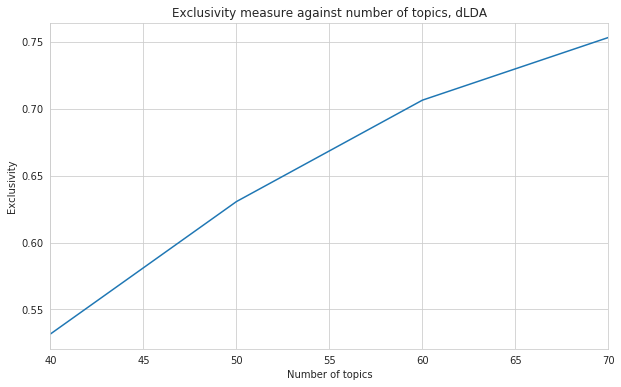

In [35]:
fig, ax = plt.subplots(figsize=(10,6))
sns.lineplot(Ks, exclusivity, ax = ax)
ax.set(xlim=(40,70),xlabel="Number of topics",ylabel="Exclusivity", title="Exclusivity measure against number of topics, dLDA")
plt.show()

### Getting coherence 

In [36]:
run_ids = [1350, 1351, 1352, 1353]

In [ ]:
get_coherence(1348)

In [37]:
stat = RunStats.objects.get(run_id=1348)
stat.coherence

0.385983051622917

In [7]:
s = pm.Search.objects.get(id=44)

In [9]:
for run_id in run_ids:
    get_coherence(run_id, s)

Getting coherence for 1350
Calculating model similarity)
Coherence obtained.
0.4095878632824845
Getting coherence for 1351
Calculating model similarity)
Coherence obtained.
0.4170903415919083
Getting coherence for 1352
Calculating model similarity)
Coherence obtained.
0.40312689734446033
Getting coherence for 1353
Calculating model similarity)
Coherence obtained.
0.41716396235815933


In [38]:
coherences = []
for run_id in run_ids:
    coherences.append(RunStats.objects.get(run_id=run_id).coherence)

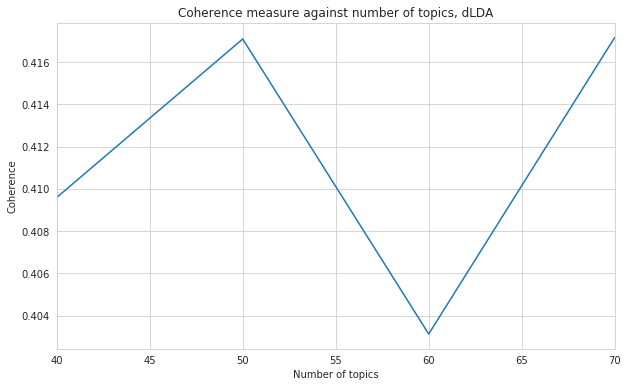

In [39]:
fig, ax = plt.subplots(figsize=(10,6))
sns.lineplot(Ks, coherences, ax = ax)
ax.set(xlim=(40,70),xlabel="Number of topics",ylabel="Coherence", title="Coherence measure against number of topics, dLDA")
plt.show()

### searchK plots

In [40]:
plot_data = {'topic': Ks, 'coherence':coherences, 'exclusivity':exclusivity}
df_plot = pd.DataFrame(data=plot_data)
df_plot

,topic,coherence,exclusivity
0,40,0.409588,0.531700
1,50,0.417090,0.630591
2,60,0.403127,0.706347
3,70,0.417164,0.753161


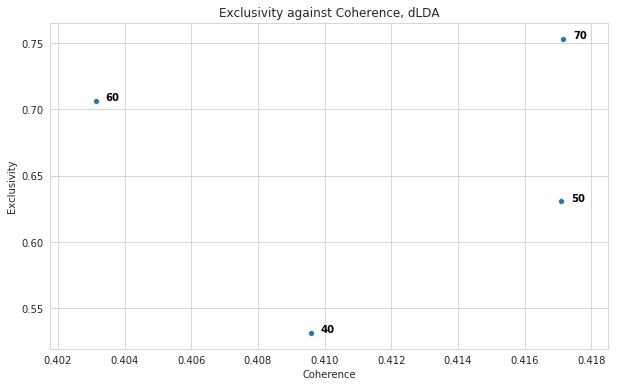

In [43]:
fig, ax = plt.subplots(figsize=(10,6))
p = sns.scatterplot(x='coherence', y='exclusivity', data=df_plot, ax = ax)

for line in range(0,df_plot.shape[0]):
     p.text(df_plot.coherence[line]+0.0003, df_plot.exclusivity[line], df_plot.topic[line], horizontalalignment='left', size='medium', color='black', weight='semibold')


ax.set(xlabel="Coherence",ylabel="Exclusivity", title="Exclusivity against Coherence, dLDA")
plt.show()

#### test for static LDA runs with more samples

In [44]:
search_word = "Kohle"
K_t = list(range(10,71,5))
method="LD"
run_ids_ld = []
for K in K_t:
    run_ids_ld.append(RunStats.objects.filter(psearch__title="{} tei utterance".format(search_word), method=method, K=K)[0].run_id)

In [45]:
sn = pm.Search.objects.get(id=33)

In [46]:
print(run_ids_ld)

[1093, 1080, 1061, 1081, 1110, 1082, 1115, 1083, 1064, 1084, 1099, 1100, 1101]


In [47]:
coherences_ld = []
for run_id in run_ids_ld:
    coherences_ld.append(RunStats.objects.get(run_id=run_id).coherence)

In [48]:
coherences_ld

[0.144700699245963,
 0.142379914593959,
 0.136165890521042,
 0.148802740569689,
 0.13678253067943,
 0.151431698286679,
 0.143412522469389,
 0.154452255455935,
 0.155044302154147,
 0.167127492554695,
 0.145805249838862,
 0.14734888263943,
 0.157193152826735]

In [53]:
get_exclusivity(1093)
stat = RunStats.objects.get(run_id=1093)
stat.exclusivity

'0.005740162000127559'

In [54]:
exclusivity_ld = []
for run_id in run_ids_ld:
    get_exclusivity(run_id)
    stat = RunStats.objects.get(run_id=run_id)
    exclusivity_ld.append(float(stat.exclusivity))
exclusivity_ld

[0.005740162000127559,
 0.008610243000191338,
 0.011480324000255117,
 0.014350405000318905,
 0.017220486000382677,
 0.020090567000446452,
 0.022965042102577195,
 0.025830729000574017,
 0.028700810000637827,
 0.031570891000701554,
 0.034440972000765395,
 0.03731105300082911,
 0.040181134000892946]

In [56]:
data_lda = {'topic': K_t, 'coherence': coherences_ld, 'exclusivity': exclusivity_ld}

df_lda = pd.DataFrame(data=data_lda)
df_lda.set_index('topic')

,coherence,exclusivity
topic,,
10,0.144701,0.005740
15,0.142380,0.008610
20,0.136166,0.011480
25,0.148803,0.014350
30,0.136783,0.017220
35,0.151432,0.020091
40,0.143413,0.022965
45,0.154452,0.025831
50,0.155044,0.028701


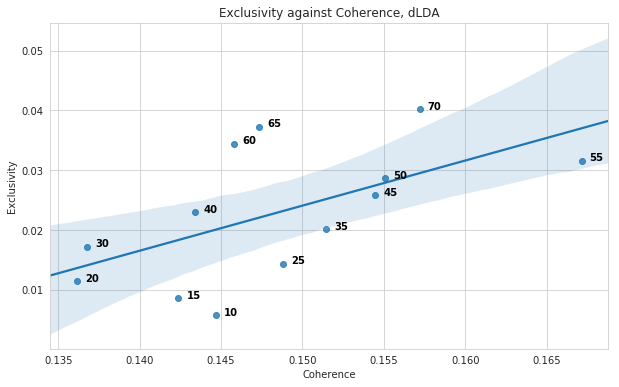

In [57]:
fig, ax = plt.subplots(figsize=(10,6))
p = sns.regplot(x='coherence', y='exclusivity', data=df_lda, ax = ax)

for line in range(0,df_lda.shape[0]):
     p.text(df_lda.coherence[line]+0.0005, df_lda.exclusivity[line], df_lda.topic[line], horizontalalignment='left', size='medium', color='black', weight='semibold')

ax.set(xlabel="Coherence",ylabel="Exclusivity", title="Exclusivity against Coherence, dLDA")
plt.show()